<a href="https://colab.research.google.com/github/khp53/Credit-Card-Fraud-Detection-SecureBoost/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sdv

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.87 requires jax>=0.4.27, but you have jax 0.4.14 which is incompatible.
chex 0.1.87 requires jaxlib>=0.4.27, but you have jaxlib 0.4.14 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
flax 0.8.5 requires jax>=0.4.27, but you have jax 0.4.14 which is incompatible.
langchain-core 0.3.19 requires packaging<25,>=23.2, but you have packaging 22.0 which is incompatible.
optax 0.2.4 requires jax>=0.4.27, but yo

In [2]:
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic
import numpy as np
import datetime as dt

In [3]:
# Load or create a dataset
real_data = pd.read_csv('creditcard.csv')

# We will need additional metadata as this dataset does not include much valuable metadata
# For PCI complience all of them are encrypted.

# External Metadata
merchant_category = ["Grocery", "Electronics", "Clothing", "Travel", "Restaurants"]
real_data["Merchant Category"] = np.random.choice(merchant_category, size=len(real_data))

device_type = ["Mobile", "Desktop", "Tablet"]
real_data["Device Type"] = np.random.choice(device_type, size=len(real_data))

locations = ["City A", "City B", "City C"]
real_data["Location"] = np.random.choice(locations, size=len(real_data))

# HEre we are using the existing time values from our real_data to calculate a time stamp for metadata
timestamp_start = dt.datetime(2022, 11, 14)
real_data["Transaction Timestamp"] = real_data["Time"].apply(lambda x: timestamp_start + dt.timedelta(days=x))

payment_methods = ["Credit Card", "Debit Card", "Apple Pay", "Google Pay", "Interact"]
real_data["Payment Method"] = np.random.choice(payment_methods, size=len(real_data))

channel = ["Online", "In-Store", "POS"]
real_data["Channel"] = np.random.choice(channel, size=len(real_data))

season = ["Winter", "Spring", "Summer", "Holiday"]
real_data["Season"] = np.random.choice(season, size=len(real_data))

card_types = ["Visa", "MasterCard", "American Express", "Discover"]
real_data["Card Type"] = np.random.choice(card_types, size=len(real_data))

real_data["Credit Limit"] = np.random.uniform(1000, 10000, size=len(real_data))
real_data["Cardholder Risk Score"] = np.random.uniform(300, 850, size=len(real_data))
real_data["Number of Active Cards"] = np.random.randint(1, 5, size=len(real_data))
real_data["Loyalty Points Available"] = np.random.randint(0, 5000, size=len(real_data))

In [4]:
def generate_card_id(card_type):
    if card_type == 'Visa':
        return '4' + ''.join(np.random.choice(list('0123456789'), size=15))
    elif card_type == 'MasterCard':
        prefix = np.random.choice(['51', '52', '53', '54', '55'] + [str(i) for i in range(2221, 2721)])
        return prefix + ''.join(np.random.choice(list('0123456789'), size=16-len(prefix)))
    elif card_type == 'American Express':
        prefix = np.random.choice(['34', '37'])
        return prefix + ''.join(np.random.choice(list('0123456789'), size=13))
    elif card_type == 'Discover':
        prefix = np.random.choice(['6011'] + [str(i) for i in range(622126, 622926)] + ['644', '645', '646', '647', '648', '649', '65'])
        return prefix + ''.join(np.random.choice(list('0123456789'), size=16-len(prefix)))
    else:
        return None

In [5]:
real_data['Card ID'] = real_data['Card Type'].apply(generate_card_id)

In [6]:
real_data.to_csv("augmented_creditcard.csv", index=False)

In [7]:
from sdv.metadata import SingleTableMetadata

augmented_data = pd.read_csv("augmented_creditcard.csv")

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(augmented_data)

print(metadata.to_dict())

# Save metadata to json for later reading
metadata.save_to_json("creditcard_metadata.json")
print("Metadata saved!")

{'columns': {'Time': {'sdtype': 'numerical'}, 'V1': {'sdtype': 'numerical'}, 'V2': {'sdtype': 'numerical'}, 'V3': {'sdtype': 'numerical'}, 'V4': {'sdtype': 'numerical'}, 'V5': {'sdtype': 'numerical'}, 'V6': {'sdtype': 'numerical'}, 'V7': {'sdtype': 'numerical'}, 'V8': {'sdtype': 'numerical'}, 'V9': {'sdtype': 'numerical'}, 'V10': {'sdtype': 'numerical'}, 'V11': {'sdtype': 'numerical'}, 'V12': {'sdtype': 'numerical'}, 'V13': {'sdtype': 'numerical'}, 'V14': {'sdtype': 'numerical'}, 'V15': {'sdtype': 'numerical'}, 'V16': {'sdtype': 'numerical'}, 'V17': {'sdtype': 'numerical'}, 'V18': {'sdtype': 'numerical'}, 'V19': {'sdtype': 'numerical'}, 'V20': {'sdtype': 'numerical'}, 'V21': {'sdtype': 'numerical'}, 'V22': {'sdtype': 'numerical'}, 'V23': {'sdtype': 'numerical'}, 'V24': {'sdtype': 'numerical'}, 'V25': {'sdtype': 'numerical'}, 'V26': {'sdtype': 'numerical'}, 'V27': {'sdtype': 'numerical'}, 'V28': {'sdtype': 'numerical'}, 'Amount': {'sdtype': 'numerical'}, 'Class': {'sdtype': 'categorical

Synthesizer is hidden because creating synthetic data takes a lot of time. I have provided both initial dataset and sysnthesized dataset

In [8]:
# json_metadata = SingleTableMetadata.load_from_json("creditcard_metadata.json")

# synthesizer = CTGANSynthesizer(json_metadata, epochs=100,
#     verbose=True)
# reduced_data = augmented_data.sample(frac=0.3, random_state=56)
# synthesizer.fit(reduced_data)

# synthetic_data = synthesizer.sample(num_rows=len(reduced_data))
# print(synthetic_data.head(5))

# synthetic_data.to_csv("synthetic_creditcard.csv", index=False)

In [9]:
from sdv.evaluation.single_table import run_diagnostic

synthetic_data_from_file = pd.read_csv("synthetic_creditcard.csv")

diagnostic = run_diagnostic(
    real_data=augmented_data,
    synthetic_data=synthetic_data_from_file,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 44/44 [00:00<00:00, 51.03it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 248.88it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [10]:
import hashlib

# Function to hash the Card ID
def hash_id(card_id):
    return hashlib.sha256(str(card_id).encode()).hexdigest()

# Hash Card ID in both datasets
synthetic_data_from_file['Card ID'] = synthetic_data_from_file['Card ID'].apply(hash_id)

synthetic_data_from_file.to_csv("synthetic_creditcard_hashed.csv", index=False)

In [12]:
synthetic_data_from_file.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class', 'Merchant Category', 'Device Type',
       'Location', 'Transaction Timestamp', 'Payment Method', 'Channel',
       'Season', 'Card Type', 'Credit Limit', 'Cardholder Risk Score',
       'Number of Active Cards', 'Loyalty Points Available', 'Card ID'],
      dtype=object)

In [13]:
bank_data = synthetic_data_from_file.drop(columns=['Merchant Category', 'Device Type', 'Location', 'Transaction Timestamp', 'Payment Method', 'Channel',
       'Season'], axis=1)

In [14]:
bank_data.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class', 'Card Type', 'Credit Limit',
       'Cardholder Risk Score', 'Number of Active Cards',
       'Loyalty Points Available', 'Card ID'], dtype=object)

In [15]:
bank_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,Amount,Class,Card Type,Credit Limit,Cardholder Risk Score,Number of Active Cards,Loyalty Points Available,Card ID
0,68183.0,-2.555683,1.046685,1.020982,1.566225,3.022399,1.321870,1.108944,-0.072699,-0.509197,...,0.462595,-0.174333,3.99,0,Visa,1938.788822,452.095477,2,3390,f145035e066bdae40996c3f91d2df1af45510a084b4bc1...
1,71429.0,1.315486,-0.371440,-0.070024,0.281124,0.334142,0.887258,0.183357,0.269768,1.117159,...,0.020163,-0.081519,15.54,0,Discover,7064.134292,711.067184,4,3762,58bd556902c91666aed510c00cee57b437940b08946505...
2,51993.0,-0.947109,1.290269,0.083987,-0.652643,1.661304,-0.653085,0.879837,-0.047507,-0.120699,...,0.270256,-0.017458,10.05,0,American Express,6450.094268,396.961578,4,2404,d1f2bafc6534a58843730b0587396bb419839ffd8f8b56...
3,64155.0,-0.302848,1.081142,0.568993,2.189436,1.593832,0.074635,0.624375,0.803518,-0.288782,...,0.009516,-0.093137,28.03,0,Visa,8966.061953,592.930310,3,2114,8445d236758721671bd893fe817c0898fd281c114026a6...
4,74694.0,2.004417,-0.660734,-0.561478,-0.188918,0.360716,-0.743623,0.224457,0.000284,-0.476166,...,0.192890,0.013850,0.00,0,American Express,4978.858676,520.304113,3,2302,9fa4f62edcd251b22fc386e19b05cff3fd5cc6401cf624...


In [16]:
synthetic_data_from_file = pd.read_csv("synthetic_creditcard_hashed.csv")
ecommerce_data = synthetic_data_from_file.drop(columns=['Credit Limit', 'Cardholder Risk Score',
       'Number of Active Cards', 'Loyalty Points Available'], axis=1)

In [17]:
ecommerce_data.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class', 'Merchant Category', 'Device Type',
       'Location', 'Transaction Timestamp', 'Payment Method', 'Channel',
       'Season', 'Card Type', 'Card ID'], dtype=object)

In [18]:
ecommerce_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,Class,Merchant Category,Device Type,Location,Transaction Timestamp,Payment Method,Channel,Season,Card Type,Card ID
0,68183.0,-2.555683,1.046685,1.020982,1.566225,3.022399,1.321870,1.108944,-0.072699,-0.509197,...,0,Clothing,Tablet,City A,sdv-pii-24p3x,Debit Card,Online,Summer,Visa,f145035e066bdae40996c3f91d2df1af45510a084b4bc1...
1,71429.0,1.315486,-0.371440,-0.070024,0.281124,0.334142,0.887258,0.183357,0.269768,1.117159,...,0,Travel,Desktop,City B,sdv-pii-ngu20,Debit Card,POS,Spring,Discover,58bd556902c91666aed510c00cee57b437940b08946505...
2,51993.0,-0.947109,1.290269,0.083987,-0.652643,1.661304,-0.653085,0.879837,-0.047507,-0.120699,...,0,Grocery,Desktop,City B,sdv-pii-kp3sm,Google Pay,In-Store,Summer,American Express,d1f2bafc6534a58843730b0587396bb419839ffd8f8b56...
3,64155.0,-0.302848,1.081142,0.568993,2.189436,1.593832,0.074635,0.624375,0.803518,-0.288782,...,0,Grocery,Mobile,City A,sdv-pii-u659p,Apple Pay,Online,Spring,Visa,8445d236758721671bd893fe817c0898fd281c114026a6...
4,74694.0,2.004417,-0.660734,-0.561478,-0.188918,0.360716,-0.743623,0.224457,0.000284,-0.476166,...,0,Restaurants,Mobile,City B,sdv-pii-ltoow,Apple Pay,Online,Spring,American Express,9fa4f62edcd251b22fc386e19b05cff3fd5cc6401cf624...


In [19]:
# Check for shared card hashes between datasets
shared_card_hashes = set(ecommerce_data['Card ID']).intersection(set(bank_data['Card ID']))
print(f"Number of shared card hashes: {len(shared_card_hashes)}")

Number of shared card hashes: 85442


Data Preprocessing

Check for distrubition of PCI features V1 to V28, they should be already standarized but I am checking to ensure.

In [20]:
# # Get a statistical summary of V1 to V28
# pca_columns = [f'V{i}' for i in range(1, 29)]
# bank_data[pca_columns].describe()

Observation from description:

The mean for V1 to V28 is close to 0, which aligns with expectations for PCA-transformed data.

The standard deviation (std) varies across components. While some are close to 1, others deviate significantly (e.g., V1 has std ≈ 1.97, V2 ≈ 1.69, and so on). This suggests that the PCA components are not uniformly scaled, which could affect models sensitive to feature magnitudes.

The min/max values for certain features indicate the presence of extreme outliers. For example:
V4 has a minimum of -113.74 and a maximum of 34.80.
V7 has a maximum of 120.59.
These extreme values may skew the distributions and impact model performance if left unhandled.

Creating density plots to check if they center around 0 with similar shapes.

In [21]:
# import matplotlib.pyplot as plt

# for column in pca_columns:
#     bank_data[column].plot(kind='density', figsize=(6, 4), title=f'Density Plot of {column}')
#     plt.xlabel(column)
#     plt.show()

Even though most of the PCA features shape around 0, some fully don't, to mitigate this we are gonna scale all the PCA features as well.

Shared features

In [22]:
# from sklearn.preprocessing import StandardScaler

# # Standardize PCA fetaures (V1 to V28)
# pca_columns = [f'V{i}' for i in range(1, 29)]
# scaler = StandardScaler()
# bank_data[pca_columns] = scaler.fit_transform(bank_data[pca_columns])
# ecommerce_data[pca_columns] = scaler.transform(ecommerce_data[pca_columns])


Check their distribution after scalling

In [23]:
# for column in pca_columns:
#     bank_data[column].plot(kind='density', figsize=(6, 4), title=f'Density Plot of {column}')
#     plt.xlabel(column)
#     plt.show()

In [24]:
# bank_data[pca_columns].describe()

Mean: The mean for all features is close to 0 (within floating-point precision limits). This is expected and aligns with standardization.

Standard Deviation: The standard deviation for all features is close to 1. This ensures that all features contribute equally during model training.

Min/Max: The ranges of some features still show extreme values. For example:
V6 has a maximum of 54.46 and V7 has a maximum of 95.35.
These values are much higher than the typical range (-3 to +3) expected for standardized data, indicating the presence of outliers.

If outliers have big impact on the model then might need to add RobustScaler instead of StandardScaler.

We do not need to add any sort of standarization in Class, Card IDs features.

Class --> is a label to detect if this transaction is fraudulant or not.

Card ID --> is an identifier which was int object but to hide the Card data to comply with PCI DSS complience we sort of Hashed it so this does not need or we cannot scale a string object.



```

```

Modified Data prep pipeline, the ones above was used to produce insights on the data, can be commented out to check.

In [25]:
# Sort both datasets by Card ID for alignment
X_bank_aligned = bank_data.sort_values('Card ID').reset_index(drop=True)
X_ecommerce_aligned = ecommerce_datasort_values('Card ID').reset_index(drop=True)

# Remove class labels from ecommerce_data
if 'Class' in X_ecommerce_aligned.columns:
    X_ecommerce_aligned = X_ecommerce_aligned.drop(columns=['Class'])

# Confirm alignment
assert all(X_bank_aligned['Card ID'] == X_ecommerce_aligned['Card ID']), "Card IDs are not aligned!"

<ipython-input-26-f96c7bab80c5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Class',data = X_bank_aligned, edgecolor = 'black', palette = colors)
<ipython-input-26-f96c7bab80c5>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Fraud','Fraud'])


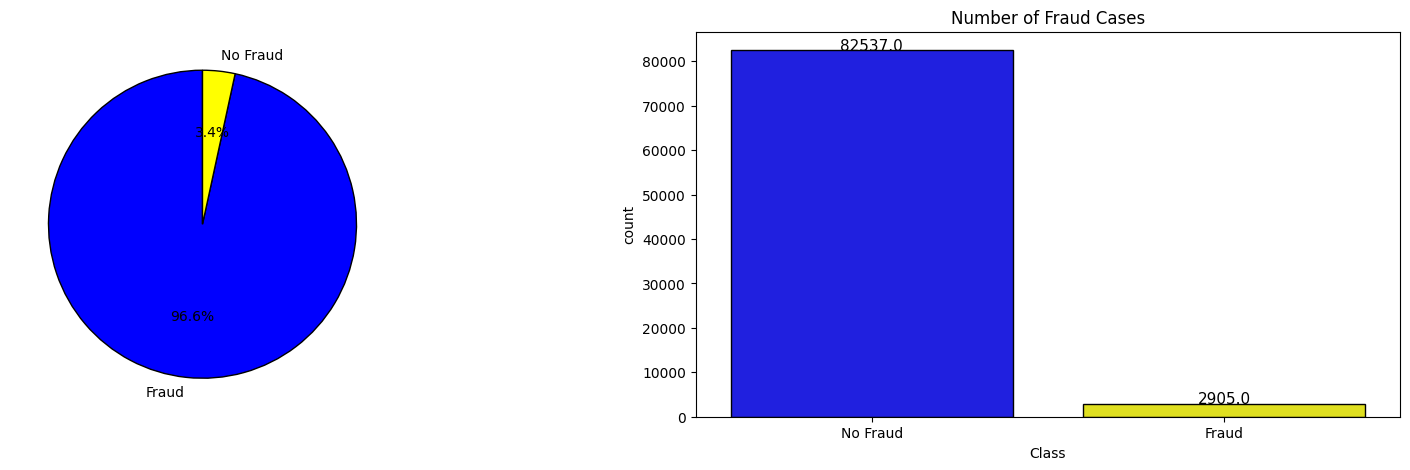

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['blue','yellow']
fraud = len(X_bank_aligned[X_bank_aligned['Class'] == 1]) / len(X_bank_aligned) * 100
nofraud = len(X_bank_aligned[X_bank_aligned['Class'] == 0]) / len(X_bank_aligned) * 100
fraud_percentage = [nofraud,fraud]

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
plt.pie(fraud_percentage,labels = ['Fraud','No Fraud'],autopct='%1.1f%%',startangle = 90,colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})

plt.subplot(1,2,2)
ax = sns.countplot(x='Class',data = X_bank_aligned, edgecolor = 'black', palette = colors)
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['No Fraud','Fraud'])
plt.title('Number of Fraud Cases');

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import tensorflow as tf

# Steps below describes how the preprocess pipeline has been Established
#
# -------------------------------
# Step 1: Define Shared and Specific Features
# -------------------------------

# Shared numerical features
shared_numerical_features = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]

# Shared categorical features
shared_categorical_features = ['Card Type', 'Card ID']

# Bank-specific numerical features
bank_specific_numerical_features = ['Credit Limit', 'Cardholder Risk Score', 'Number of Active Cards', 'Loyalty Points Available']

# E-commerce-specific categorical features
ecommerce_specific_categorical_features = ['Merchant Category', 'Payment Method', 'Channel', 'Location', 'Device Type', 'Season']

# -------------------------------
# Step 2: Prepare Bank Data
# -------------------------------

# Separate features and labels
X_bank = X_bank_aligned[shared_numerical_features + shared_categorical_features + bank_specific_numerical_features]
y_bank = X_bank_aligned['Class']

# Split bank data into training and test sets
X_bank_train, X_bank_test, y_bank_train, y_bank_test = train_test_split(
    X_bank, y_bank, test_size=0.2, random_state=42, stratify=y_bank)

# -------------------------------
# Step 3: Prepare E-commerce Data
# -------------------------------

X_ecommerce = X_ecommerce_aligned[shared_numerical_features + shared_categorical_features + ecommerce_specific_categorical_features]

# -------------------------------
# Step 4: Apply Frequency Encoding to Categorical Features
# -------------------------------

def compute_frequency_map(df, categorical_cols):
    freq_maps = {}
    for col in categorical_cols:
        freq_maps[col] = df[col].value_counts()
    return freq_maps

def apply_frequency_encoding(df, freq_maps):
    df = df.copy()
    for col, freq in freq_maps.items():
        df[col + '_freq'] = df[col].map(freq).fillna(0)
    return df

# 4.a. Compute frequency maps for shared categorical features using bank training data
shared_freq_maps = compute_frequency_map(X_bank_train, shared_categorical_features)

# 4.b. Apply frequency encoding to shared categorical features in bank data
X_bank_train_encoded = apply_frequency_encoding(X_bank_train, shared_freq_maps)
X_bank_test_encoded = apply_frequency_encoding(X_bank_test, shared_freq_maps)

# 4.c. Apply frequency encoding to shared categorical features in e-commerce data
X_ecommerce_encoded = apply_frequency_encoding(X_ecommerce, shared_freq_maps)

# 4.d. Compute frequency maps for e-commerce-specific categorical features using e-commerce data
ecommerce_freq_maps = compute_frequency_map(X_ecommerce, ecommerce_specific_categorical_features)

# 4.e. Apply frequency encoding to e-commerce-specific categorical features in e-commerce data
X_ecommerce_encoded = apply_frequency_encoding(X_ecommerce_encoded, ecommerce_freq_maps)

# 4.f. Drop original categorical features
X_bank_train_encoded.drop(columns=shared_categorical_features, inplace=True)
X_bank_test_encoded.drop(columns=shared_categorical_features, inplace=True)
X_ecommerce_encoded.drop(columns=shared_categorical_features + ecommerce_specific_categorical_features, inplace=True)

# 4.g. Add placeholder columns for e-commerce-specific encoded features in bank data
for col in ecommerce_specific_categorical_features:
    encoded_col = col + '_freq'
    X_bank_train_encoded[encoded_col] = 0
    X_bank_test_encoded[encoded_col] = 0

# -------------------------------
# Step 5: Extract and Process Time Features from E-commerce Data
# -------------------------------

# Function to extract time features
def extract_time_features(df):
    df = df.copy()
    df['Transaction Timestamp'] = pd.to_datetime(df['Transaction Timestamp'], errors='coerce')
    df['hour'] = df['Transaction Timestamp'].dt.hour.fillna(0)
    df['day_of_week'] = df['Transaction Timestamp'].dt.dayofweek.fillna(0)
    df['month'] = df['Transaction Timestamp'].dt.month.fillna(0)
    return df[['hour', 'day_of_week', 'month']]

# Extract time features from e-commerce data
ecommerce_time_features = extract_time_features(ecommerce_data)

# Add time features to e-commerce data
X_ecommerce_encoded.reset_index(drop=True, inplace=True)
ecommerce_time_features.reset_index(drop=True, inplace=True)
X_ecommerce_encoded = pd.concat([X_ecommerce_encoded, ecommerce_time_features], axis=1)

# Add placeholder time features to bank data
for col in ['hour', 'day_of_week', 'month']:
    X_bank_train_encoded[col] = 0
    X_bank_test_encoded[col] = 0


# Add placeholder columns for bank-specific features in e-commerce data
for col in bank_specific_numerical_features:
    X_ecommerce_encoded[col] = 0

# -------------------------------
# Step 6: Preprocess Numerical Features
# -------------------------------

# Create lists of frequency-encoded feature names
shared_freq_encoded_features = [col + '_freq' for col in shared_categorical_features]
ecommerce_specific_freq_encoded_features = [col + '_freq' for col in ecommerce_specific_categorical_features]
time_feature_cols = ['hour', 'day_of_week', 'month']

# Combine all feature names
all_features = shared_numerical_features + shared_freq_encoded_features + \
               bank_specific_numerical_features + ecommerce_specific_freq_encoded_features + \
               time_feature_cols

# Ensure all DataFrames have the same columns in the same order
X_bank_train_encoded = X_bank_train_encoded[all_features]
X_bank_test_encoded = X_bank_test_encoded[all_features]
X_ecommerce_encoded = X_ecommerce_encoded[all_features]

# Fill any missing values with zeros
X_bank_train_encoded.fillna(0, inplace=True)
X_bank_test_encoded.fillna(0, inplace=True)
X_ecommerce_encoded.fillna(0, inplace=True)

# Define numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Fit transformer on the bank's training data
numerical_transformer.fit(X_bank_train_encoded)

# Transform bank data
X_bank_train_processed = numerical_transformer.transform(X_bank_train_encoded)
X_bank_test_processed = numerical_transformer.transform(X_bank_test_encoded)

# Transform e-commerce data
X_ecommerce_processed = numerical_transformer.transform(X_ecommerce_encoded)

# -------------------------------
# Step 7: Apply SMOTE to Bank Training Data
# -------------------------------

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_bank_train_resampled, y_bank_train_resampled = smote.fit_resample(X_bank_train_processed, y_bank_train)

# -------------------------------
# Step 8: Prepare Data for Federated Learning
# -------------------------------

# Convert bank test labels to numpy array
y_bank_test = y_bank_test.values

# -------------------------------
# Step 9: Create TensorFlow Datasets
# -------------------------------

# Bank data (labeled)
# Convert bank training labels to integers
y_bank_train_resampled = y_bank_train_resampled.astype(np.int64)

# Convert bank test labels to integers
y_bank_test = y_bank_test.astype(np.int64)

bank_train_data = tf.data.Dataset.from_tensor_slices((X_bank_train_resampled, y_bank_train_resampled))
bank_test_data = tf.data.Dataset.from_tensor_slices((X_bank_test_processed, y_bank_test))

# E-commerce data (unlabeled)
pseudo_labels_ecommerce = np.zeros(len(X_ecommerce_processed), dtype=np.int64)
ecommerce_data_tf = tf.data.Dataset.from_tensor_slices((X_ecommerce_processed, pseudo_labels_ecommerce))

# -------------------------------
# Step 10: Preprocess Datasets for Training
# -------------------------------

def preprocess(dataset):
    return dataset.shuffle(buffer_size=1024).batch(32)

# Preprocess datasets
bank_client_data = preprocess(bank_train_data)
ecommerce_client_data = preprocess(ecommerce_data_tf)

# Federated dataset
federated_train_data = [bank_client_data, ecommerce_client_data]

# -------------------------------
# Step 11: Verify Data Shapes
# -------------------------------

print("Bank training data shape:", X_bank_train_resampled.shape)
print("Bank test data shape:", X_bank_test_processed.shape)
print("E-commerce data shape:", X_ecommerce_processed.shape)

# All shapes should match in the number of columns
assert X_bank_train_resampled.shape[1] == X_bank_test_processed.shape[1] == X_ecommerce_processed.shape[1], \
    "Feature dimensions do not match across datasets."

# -------------------------------
# Use this dataset (federated_train_data) for model training !!IMPORTANT
# -------------------------------


ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.10/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


Bank training data shape: (132058, 45)
Bank test data shape: (17089, 45)
E-commerce data shape: (85442, 45)


In [28]:
y_bank_train_resampled.head()

,Class
0,0
1,0
2,0
3,0
4,0


([<matplotlib.patches.Wedge at 0x7b1d15b0ceb0>,
 [Text(-1.1, 1.3471114790620887e-16, 'Fraud'),
  Text(1.1, -2.6942229581241775e-16, 'No Fraud')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.6, -1.4695761589768238e-16, '50.0%')])

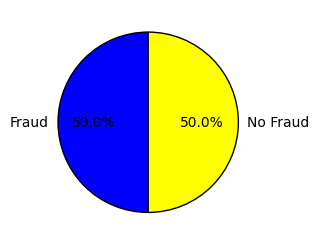

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['blue','yellow']
fraud = len(y_bank_train_resampled[y_bank_train_resampled == 1]) / len(y_bank_train_resampled) * 100
nofraud = len(y_bank_train_resampled[y_bank_train_resampled == 0]) / len(y_bank_train_resampled) * 100
fraud_percentage = [nofraud,fraud]

plt.subplot(1,2,1)
plt.pie(fraud_percentage,labels = ['Fraud','No Fraud'],autopct='%1.1f%%',startangle = 90,colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})

A lot of trail and error was done, did not want to remove the code so commented it out, uncommenting will break the project !!IMPORTANT

In [30]:
# X_bank_final = X_bank_final.astype('float32')
# X_ecommerce_final = X_ecommerce_final.astype('float32')
# y_bank = y_bank.astype('int8')

# X_bank_final = X_bank_final.reset_index(drop=True)
# X_ecommerce_final = X_ecommerce_final.reset_index(drop=True)
# y_bank = y_bank.reset_index(drop=True)

# from scipy.sparse import csr_matrix

# # Ensure data is sparse
# X_bank_final_sparse = csr_matrix(X_bank_final)

# # Train-test split for the bank dataset
# X_bank_train, X_bank_test, y_bank_train, y_bank_test = train_test_split(
#     X_bank_final_sparse, y_bank, test_size=0.2, stratify=y_bank, random_state=42
# )
# print(f"X_bank_train shape: {X_bank_train.shape}")
# print(f"X_bank_test shape: {X_bank_test.shape}")



In [31]:
# X_bank_train_dense = pd.DataFrame(X_bank_train.toarray())
# X_bank_test_dense = pd.DataFrame(X_bank_test.toarray())

# train_indices = X_bank_train_dense.index.values
# test_indices = X_bank_test_dense.index.values

# # Align e-commerce dataset with the bank dataset splits
# # e_commerce_train = X_ecommerce_final.iloc[train_indices, :]
# # e_commerce_test = X_ecommerce_final.iloc[test_indices, :]

# X_ecommerce_sparse = csr_matrix(X_ecommerce_final)

# e_commerce_train = X_ecommerce_sparse[X_bank_train_dense.index]
# e_commerce_test = X_ecommerce_sparse[X_bank_test_dense.index]

In [32]:
# print(f"e_commerce_train shape: {e_commerce_train.shape}")
# print(f"e_commerce_test shape: {e_commerce_test.shape}")

In [33]:
# e_commerce_train_dense = pd.DataFrame(e_commerce_train.toarray())
# e_commerce_test_dense = pd.DataFrame(e_commerce_test.toarray())

In [34]:
# X_bank_train_dense.to_csv("X_bank_train_dense.csv", index=False)
# X_bank_test_dense.to_csv("X_bank_test_dense.csv", index=False)
# y_bank_train.to_csv("y_bank_train.csv", index=False)
# y_bank_test.to_csv("y_bank_test.csv", index=False)

# e_commerce_train_dense.to_csv("e_commerce_train_dense.csv", index=False)
# e_commerce_test_dense.to_csv("e_commerce_test_dense.csv", index=False)

Resampleling can only be applied to active party since it holds the lable.

In [35]:
# from imblearn.over_sampling import SMOTE
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# import pandas as pd

# # Fetch the data from csv
# X_bank_train = pd.read_csv('X_bank_train_dense.csv', low_memory=True, parse_dates=False, nrows=15000)
# X_bank_test = pd.read_csv('X_bank_test_dense.csv', low_memory=True, parse_dates=False, nrows=15000)

# y_bank_train = pd.read_csv('y_bank_train.csv', low_memory=True, parse_dates=False, nrows=15000)
# y_bank_test = pd.read_csv('y_bank_test.csv', low_memory=True, parse_dates=False, nrows=15000)

# e_commerce_train = pd.read_csv('e_commerce_train_dense.csv', low_memory=True, parse_dates=False, nrows=15000)
# e_commerce_test = pd.read_csv('e_commerce_test_dense.csv', low_memory=True, parse_dates=False, nrows=15000)

# # Apply SMOTE to the bank dataset (requires labels)
# smote = SMOTE(random_state=42)
# X_bank_train_resampled, y_bank_train_resampled = smote.fit_resample(X_bank_train, y_bank_train)

# # Checking results
# print(f"Original X_bank_train shape: {X_bank_train.shape}")
# print(f"Resampled X_bank_train shape: {X_bank_train_resampled.shape}")
# print(f"Original y_bank_train distribution:\n{y_bank_train.value_counts()}")
# print(f"Resampled y_bank_train distribution:\n{pd.Series(y_bank_train_resampled).value_counts()}")

In [36]:
# X_bank_train_resampled.to_csv("X_bank_train_resampled.csv", index=False)
# y_bank_train_resampled.to_csv("y_bank_train_resampled.csv", index=False)

In [37]:
# from sklearn.datasets import dump_svmlight_file

# # Save bank sparse data in LibSVM format
# dump_svmlight_file(X_bank_train, y_bank_train, "bank_sparse.libsvm", zero_based=True)

# # Save e-commerce sparse data without labels
# dump_svmlight_file(e_commerce_train, np.zeros(e_commerce_train.shape[0]), "ecommerce_sparse.libsvm", zero_based=True)


In [38]:
# from flow import FateFlow

# fate_flow = FateFlow(host="10.0.0.249", port=8000)

# # Upload bank data
# fate_flow.data.upload(
#     name="bank_sparse",
#     namespace="bank_namespace",
#     file="bank_sparse.libsvm",
#     head=0
# )

# # Upload e-commerce data
# fate_flow.data.upload(
#     name="ecommerce_sparse",
#     namespace="ecommerce_namespace",
#     file="ecommerce_sparse.libsvm",
#     head=1
# )


In [39]:
# response = fate_flow.job.submit(conf_path="secureboost_pipeline.json")
# print("Job submitted successfully. Job ID:", response.get("jobId"))


In [40]:
# job_id = response.get("jobId")

# # Query job status
# status = fate_flow.job.query(job_id=job_id)
# print("Job status:", status)


In [41]:
# !pip install fate_client

In [42]:
# !pipeline --help

In [43]:
# !pipeline init --ip 10.0.0.249 --port 9380

This is tricky! When first running the project uncomment this TFF install and restart the runtime, then recomment it, other wise project will not work and you will get a error at this line
state = iterative_process.initialize()

In [44]:
#!pip install tensorflow tensorflow-federated

In [46]:
# Prepare for federated learning
import tensorflow as tf
import tensorflow_federated as tff

# Define the model
def create_keras_model():
    model = tf.keras.models.Sequential([
        # Input Layer with increased neurons
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_bank_train_resampled.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        # Hidden Layers
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        # Output Layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=bank_client_data.element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )

# Define client and server optimizers
client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.1)
server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=1.0)

# Build the federated averaging process
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=client_optimizer_fn,
    server_optimizer_fn=server_optimizer_fn
)

# Initialize the server state
state = iterative_process.initialize()

# Train for a few rounds
NUM_ROUNDS = 30
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics={metrics}')


Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.10/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9917977), ('precision', 0.98853284), ('recall', 0.9844008), ('auc', 0.9980743), ('loss', 0.029877985), ('num_examples', 217500), ('num_batches', 6798)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9938621), ('precision', 0.9930795), ('recall', 0.9866574), ('auc', 0.9989752), ('loss', 0.021153538), ('num_examples', 217500), ('num_batches', 6798)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.9944965), ('precision', 0.9938151), ('recall', 0.988

In [47]:
print(tff.__version__)

0.84.0


In [51]:
# Extract the trained model parameters
model_weights = iterative_process.get_model_weights(state)

# Create a new Keras model instance
evaluation_model = create_keras_model()

# Assign the trained weights to the new model
model_weights.assign_weights_to(evaluation_model)

# Compile the model for evaluation
evaluation_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]
)

# Evaluate on the bank's test data
evaluation_results = evaluation_model.evaluate(X_bank_test_processed, y_bank_test, verbose=2)

print(evaluation_model.evaluate(X_bank_test_processed, y_bank_test, verbose=2))
# Extract the metric names and their corresponding values
metric_names = ['loss', 'binary_accuracy', 'precision', 'recall', 'auc']
metric_values = dict(zip(metric_names, evaluation_results))
print("Evaluation Metrics:", metric_values)


535/535 - 1s - loss: 2.2452 - binary_accuracy: 0.0348 - precision_1: 0.0340 - recall_1: 1.0000 - auc_1: 0.9739 - 1s/epoch - 2ms/step
535/535 - 1s - loss: 2.2452 - binary_accuracy: 0.0348 - precision_1: 0.0340 - recall_1: 1.0000 - auc_1: 0.9739 - 849ms/epoch - 2ms/step
[2.245213747024536, 0.03475920110940933, 0.03402436152100563, 1.0, 0.9739288687705994]
Evaluation Metrics: {'loss': 2.245213747024536, 'binary_accuracy': 0.03475920110940933, 'precision': 0.03402436152100563, 'recall': 1.0, 'auc': 0.9739288687705994}


In [52]:
# Calculate F1-score
precision = metric_values['precision']
recall = metric_values['recall']
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)  # Add epsilon to avoid division by zero

# Add F1-score to the metrics dictionary
metric_values['f1_score'] = f1_score
print(f"F1-Score: {f1_score:.4f}")


F1-Score: 0.0658


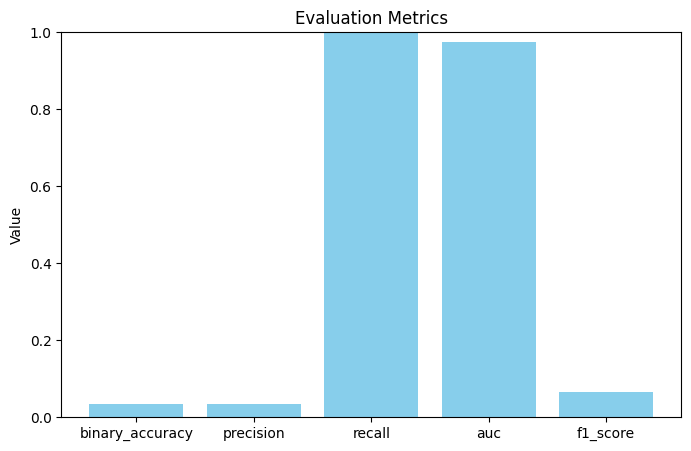

In [53]:
import matplotlib.pyplot as plt

# Metrics to visualize
metrics_to_plot = ['binary_accuracy', 'precision', 'recall', 'auc', 'f1_score']
values_to_plot = [metric_values[m] for m in metrics_to_plot]

# Plot the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_to_plot, values_to_plot, color='skyblue')
plt.title('Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)  # Metrics are probabilities, so limit y-axis to 1
plt.show()


535/535 [==============================] - 1s 2ms/step


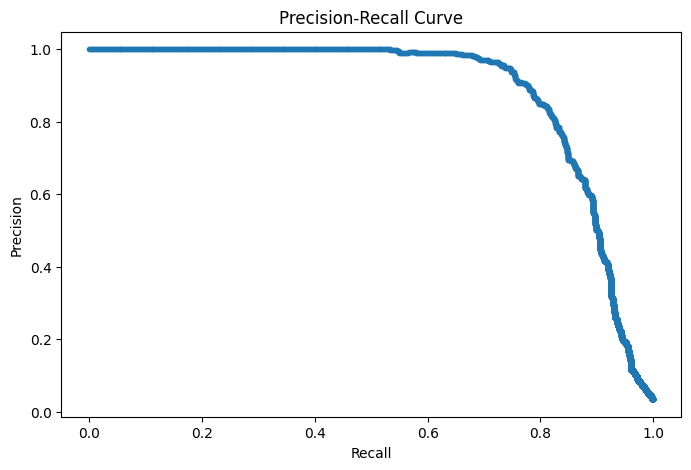

In [54]:
from sklearn.metrics import precision_recall_curve

# Get model predictions on the test set
y_pred_probs = evaluation_model.predict(X_bank_test_processed).ravel()

# Compute precision-recall pairs for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_bank_test, y_pred_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


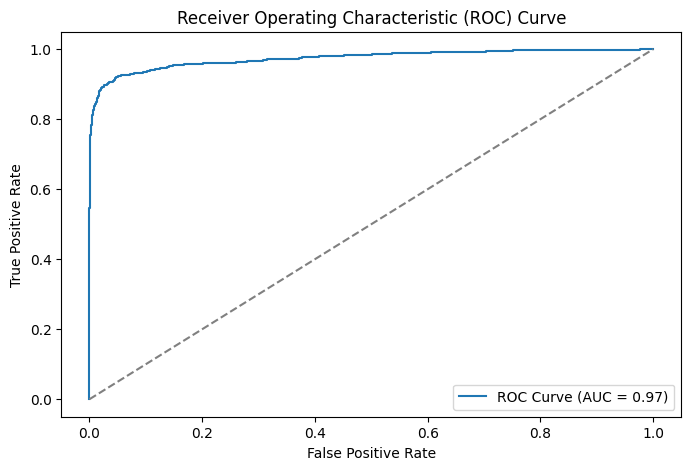

In [55]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_bank_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Generating Counterfactual Explanation using DiCE

In [56]:
!pip install dice-ml

In [57]:
import pandas as pd

# Use the feature names from 'all_features'
X_test_df = pd.DataFrame(X_bank_test_processed, columns=all_features)

# Add the target variable
X_test_df['Class'] = y_bank_test


Data interfcae

In [58]:
import dice_ml
from dice_ml import Data

# Define feature types
continuous_features = all_features  # Adjust if you have categorical features
categorical_features = []  # Specify categorical features if any

data_dice = Data(dataframe=X_test_df,
                 continuous_features=continuous_features,
                 outcome_name='Class')


Model interface

In [59]:
from dice_ml import Model

model_dice = Model(model=evaluation_model, backend='TF2', model_type='classifier')


DICE explainer init

In [60]:
from dice_ml import Dice

exp = Dice(data_dice, model_dice, method='random')


We now select a fraud transaction to get explanation

In [61]:
# Get model predictions
y_pred_probs = evaluation_model.predict(X_bank_test_processed).ravel()
y_pred = (y_pred_probs >= 0.5).astype(int)

# Find indices of transactions predicted as fraud
fraud_indices = [i for i, pred in enumerate(y_pred) if pred == 1]

if fraud_indices:
    idx = fraud_indices[0]  # Take the first one
    query_instance = X_test_df.iloc[[idx]]
else:
    print("No transactions predicted as fraud in the test set.")

    fraud_indices = np.where(y_bank_test == 1)[0]
    idx = fraud_indices[0]
    query_instance = X_test_df.iloc[[idx]]
    print(query_instance)


535/535 [==============================] - 1s 2ms/step


Generate explanations

In [62]:
# Prepare the query instance
query_instance_features = query_instance.drop(columns=['Class'])

print(type(query_instance_features))
print(query_instance_features)

# Specify immutable features if any
immutable_features = ['Card ID']

# Generate counterfactual explanations
dice_exp = exp.generate_counterfactuals(query_instance_features,
                                        total_CFs=3,
                                        desired_class=0,
                                        features_to_vary='all')


<class 'pandas.core.frame.DataFrame'>
       Time    Amount        V1        V2        V3        V4        V5  \
0 -0.274607 -0.454666  0.599651 -1.008848  0.259652  0.295509  0.322974   

         V6        V7        V8  ...  Loyalty Points Available  \
0 -0.253823  0.277593  0.436191  ...                  0.725861   

   Merchant Category_freq  Payment Method_freq  Channel_freq  Location_freq  \
0                     0.0                  0.0           0.0            0.0   

   Device Type_freq  Season_freq  hour  day_of_week  month  
0               0.0          0.0   0.0          0.0    0.0  

[1 rows x 45 columns]


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Visualize explanation

In [63]:
# Check the model's prediction for the query instance
prediction = evaluation_model.predict(query_instance_features)
print("Model prediction for query instance:", prediction)


1/1 [==============================] - 0s 104ms/step
Model prediction for query instance: [[0.89687073]]


In [64]:
# Display the counterfactual examples
dice_exp.visualize_as_dataframe()


Query instance (original outcome : 1)


,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,Merchant Category_freq,Payment Method_freq,Channel_freq,Location_freq,Device Type_freq,Season_freq,hour,day_of_week,month,Class
0,-0.274607,-0.454666,0.599651,-1.008848,0.259652,0.295509,0.322974,-0.253823,0.277593,0.436191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1



Diverse Counterfactual set (new outcome: 0)


,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,Merchant Category_freq,Payment Method_freq,Channel_freq,Location_freq,Device Type_freq,Season_freq,hour,day_of_week,month,Class
0,-0.274607,13.818929,0.599651,-1.008848,0.259652,0.295509,0.322974,-0.253823,0.277593,-7.775500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.274607,11.870461,0.599651,-1.008848,0.259652,0.295509,0.322974,-0.253823,0.277593,0.436191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.274607,14.076282,0.599651,-1.008848,0.259652,0.295509,0.322974,-0.253823,0.277593,0.436191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
